# Kaggle : Gemstone Price Prediction
https://www.kaggle.com/competitions/playground-series-s3e8/overview

In [1]:
#0 Load libraries

import numpy as np
import pandas as pd

import altair as alt
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')
# Include an image for each plot since Gradescope only supports displaying plots as images
alt.renderers.enable('mimetype')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.model_selection import RandomizedSearchCV

## 1. Load data and pre-processing

In [2]:
#1.1 Load train data
train_df = pd.read_csv('data/train.csv')
train_df.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


In [3]:
#1.2 Load test data
test_df = pd.read_csv('data/test.csv')
test_df.head()

,id,carat,cut,color,clarity,depth,table,x,y,z
0,193573,0.35,Ideal,D,VS2,62.3,56.0,4.51,4.54,2.82
1,193574,0.77,Very Good,F,SI2,62.8,56.0,5.83,5.87,3.68
2,193575,0.71,Ideal,I,VS2,61.9,53.0,5.77,5.74,3.55
3,193576,0.33,Ideal,G,VVS2,61.6,55.0,4.44,4.42,2.73
4,193577,1.20,Very Good,I,VS2,62.7,56.0,6.75,6.79,4.24


In [4]:
#1.3 Check info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       193573 non-null  int64  
 1   carat    193573 non-null  float64
 2   cut      193573 non-null  object 
 3   color    193573 non-null  object 
 4   clarity  193573 non-null  object 
 5   depth    193573 non-null  float64
 6   table    193573 non-null  float64
 7   x        193573 non-null  float64
 8   y        193573 non-null  float64
 9   z        193573 non-null  float64
 10  price    193573 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 16.2+ MB


In [5]:
#1.4 Confirm NA
train_df.isna().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

In [6]:
#1.5 Splitting data with 70-30 ratio
train, test = train_test_split(train_df, test_size=0.3, shuffle=True, random_state=123)
train.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
139244,139244,0.41,Ideal,E,VS1,62.6,56.0,4.77,4.73,2.97,1073
146166,146166,0.30,Very Good,G,SI2,62.5,57.0,4.24,4.28,2.66,365
43536,43536,0.38,Ideal,E,VS2,61.8,54.0,4.66,4.69,2.89,935
151742,151742,2.11,Premium,F,SI2,61.0,60.0,8.29,8.33,5.06,14067
86034,86034,0.31,Ideal,E,SI1,61.5,55.0,4.38,4.40,2.70,489


In [7]:
#1.6 Copy test data
dep = test_df.copy()

In [8]:
#1.7 Check size of each dataset
print('Train data -shape', train.shape)
print('Test data  -shape', test.shape)
print('Dep data   -shape', dep.shape)

Train data -shape (135501, 11)
Test data  -shape (58072, 11)
Dep data   -shape (129050, 10)


## 2. EDA

In [9]:
#2.1 Check info
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135501 entries, 139244 to 15725
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       135501 non-null  int64  
 1   carat    135501 non-null  float64
 2   cut      135501 non-null  object 
 3   color    135501 non-null  object 
 4   clarity  135501 non-null  object 
 5   depth    135501 non-null  float64
 6   table    135501 non-null  float64
 7   x        135501 non-null  float64
 8   y        135501 non-null  float64
 9   z        135501 non-null  float64
 10  price    135501 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 12.4+ MB


In [10]:
#2.2 Pulling all features
train.columns

Index(['id', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y',
       'z', 'price'],
      dtype='object')

In [11]:
#2.3 Separate features into each group
numerical_features = ['carat', 'depth', 'table', 'x', 'y', 'z', 'price']
discreteized_features = []
categorical_features = ['cut', 'color', 'clarity']
text_features = []
drop_features = ['id']

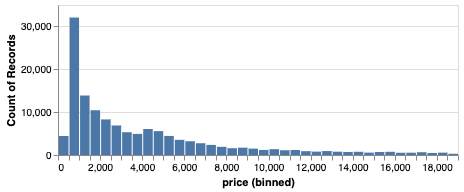

In [12]:
#2.3.1 Numerical feature distributions - price
hist = alt.Chart(train).mark_bar().encode(
     x = alt.X('price', type='quantitative', bin=alt.Bin(maxbins=40)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
hist

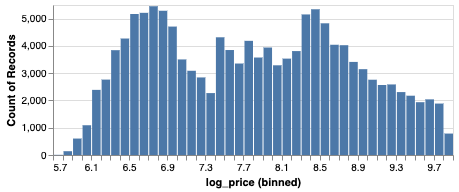

In [13]:
#2.3.2 Numerical feature distributions - log_price
train['log_price'] = np.log(train['price'])
hist = alt.Chart(train).mark_bar().encode(
     x = alt.X('log_price', type='quantitative', bin=alt.Bin(maxbins=50)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
hist

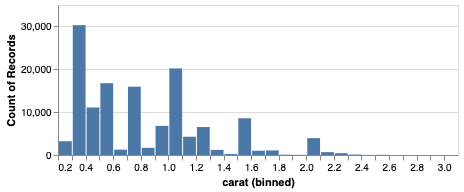

In [14]:
#2.3.3 Numerical feature distributions - carat
hist = alt.Chart(train).mark_bar().encode(
     x = alt.X('carat', type='quantitative', bin=alt.Bin(maxbins=50)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
hist

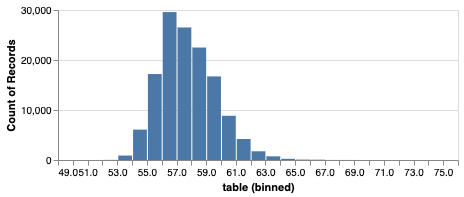

In [15]:
#2.3.4 Numerical feature distributions - table
hist = alt.Chart(train).mark_bar().encode(
     x = alt.X('table', type='quantitative', bin=alt.Bin(maxbins=50)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
hist

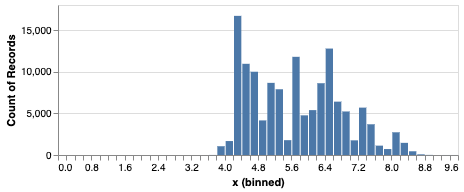

In [16]:
#2.3.5 Numerical feature distributions - x
hist = alt.Chart(train).mark_bar().encode(
     x = alt.X('x', type='quantitative', bin=alt.Bin(maxbins=50)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
hist

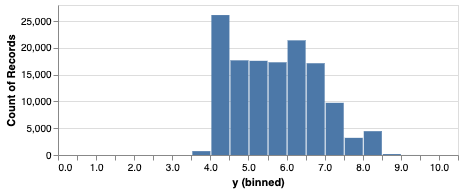

In [17]:
#2.3.6 Numerical feature distributions - y
hist = alt.Chart(train).mark_bar().encode(
     x = alt.X('y', type='quantitative', bin=alt.Bin(maxbins=50)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
hist

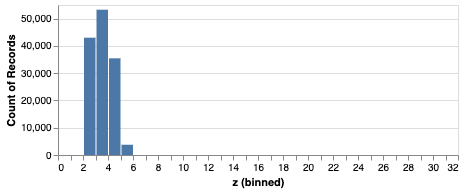

In [18]:
#2.3.7 Numerical feature distributions - z
hist = alt.Chart(train).mark_bar().encode(
     x = alt.X('z', type='quantitative', bin=alt.Bin(maxbins=50)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
hist

In [19]:
#2.3.8.1 Categorical feature distributions - cut - value_counts()
train['cut'].value_counts()

Ideal        64560
Premium      34850
Very Good    26584
Good          8076
Fair          1431
Name: cut, dtype: int64

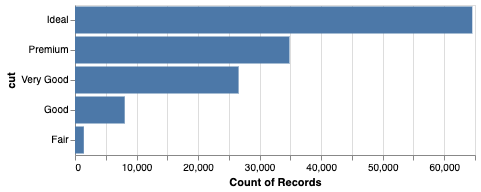

In [20]:
#2.3.8.2 Categorical feature distributions - cut
bar = alt.Chart(train).mark_bar().encode(
    x = 'count()',
    y = alt.Y('cut', type='nominal', sort='-x')
     ,
).properties(
    width=400,
    height=150
)
# Show the plot
bar

In [21]:
#2.3.9.1 Categorical feature distributions - color - value_counts()
train['color'].value_counts()

G    31096
E    25103
F    24028
H    21601
D    16848
I    12312
J     4513
Name: color, dtype: int64

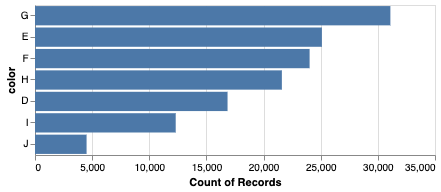

In [22]:
#2.3.9.2 Categorical feature distributions - color
bar = alt.Chart(train).mark_bar().encode(
    x = 'count()',
    y = alt.Y('color', type='nominal', sort='-x')
     ,
).properties(
    width=400,
    height=150
)
# Show the plot
bar

In [23]:
#2.3.10.1 Categorical feature distributions - clarity - value_counts()
train['clarity'].value_counts()

SI1     37229
VS2     33521
VS1     21567
SI2     21247
VVS2    11143
VVS1     7450
IF       2982
I1        362
Name: clarity, dtype: int64

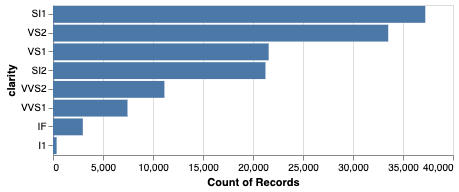

In [24]:
#2.3.9.10 Categorical feature distributions - clarity
bar = alt.Chart(train).mark_bar().encode(
    x = 'count()',
    y = alt.Y('clarity', type='nominal', sort='-x')
     ,
).properties(
    width=400,
    height=150
)
# Show the plot
bar

In [25]:
#2.4 Correlation matrix : Spearman
train.corr('pearson').style.background_gradient().format(precision=2)

,id,carat,depth,table,x,y,z,price,log_price
id,1.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00
carat,-0.00,1.00,0.03,0.23,0.98,0.98,0.97,0.94,0.94
depth,0.00,0.03,1.00,-0.23,-0.01,-0.01,0.08,0.00,0.01
table,0.00,0.23,-0.23,1.00,0.24,0.23,0.21,0.17,0.21
x,-0.00,0.98,-0.01,0.24,1.00,1.00,0.99,0.90,0.97
y,-0.00,0.98,-0.01,0.23,1.00,1.00,0.99,0.90,0.97
z,0.00,0.97,0.08,0.21,0.99,0.99,1.00,0.89,0.96
price,-0.00,0.94,0.00,0.17,0.90,0.90,0.89,1.00,0.90
log_price,-0.00,0.94,0.01,0.21,0.97,0.97,0.96,0.90,1.00


In [26]:
#2.5 Correlation matrix : Spearman
train.corr('spearman').style.background_gradient().format(precision=2)

,id,carat,depth,table,x,y,z,price,log_price
id,1.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00
carat,-0.00,1.00,0.04,0.24,1.00,1.00,1.00,0.97,0.97
depth,0.00,0.04,1.00,-0.16,-0.01,-0.01,0.11,0.03,0.03
table,0.00,0.24,-0.16,1.00,0.24,0.23,0.21,0.22,0.22
x,-0.00,1.00,-0.01,0.24,1.00,1.00,0.99,0.97,0.97
y,-0.00,1.00,-0.01,0.23,1.00,1.00,0.99,0.97,0.97
z,0.00,1.00,0.11,0.21,0.99,0.99,1.00,0.97,0.97
price,0.00,0.97,0.03,0.22,0.97,0.97,0.97,1.00,1.00
log_price,0.00,0.97,0.03,0.22,0.97,0.97,0.97,1.00,1.00


## 3. Feature engineering and Feature selection

In [27]:
train.columns

Index(['id', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y',
       'z', 'price', 'log_price'],
      dtype='object')

In [29]:
test.columns

Index(['id', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y',
       'z', 'price'],
      dtype='object')

In [30]:
#3.1 Separate X_train, y_train, X_test, y_test
train['price'] = train['log_price']
test['price'] = np.log(test['price'])
X_train = train.drop(columns=['price'])
X_test = test.drop(columns=['price'])
y_train = train['price']
y_test = test['price']

In [31]:
#3.2 Check colnume names
X_train.columns

Index(['id', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y',
       'z', 'log_price'],
      dtype='object')

In [32]:
#3.3 setup feature types
numerical_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
categorical_features = ['cut', 'color', 'clarity']
drop_features = ['id','log_price']

cut_list = ['Ideal','Premium','Very Good','Good','Fair']
color_list = ['D','E','F','G','H','I','J']
clarity_list = ['IF','VVS1','VVS2','VS1','VS2','SI1','SI2','I1']

# 3.4 define pre-processor
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_features),
    # (OneHotEncoder(handle_unknown="ignore"), categorical_features), 
    (OrdinalEncoder(categories=[cut_list,color_list,clarity_list], dtype=int, handle_unknown='error'), categorical_features),
    ("drop", drop_features)
)
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['carat', 'depth', 'table', 'x', 'y', 'z']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['Ideal', 'Premium',
                                                             'Very Good',
                                                             'Good', 'Fair'],
                                                            ['D', 'E', 'F', 'G',
                                                             'H', 'I', 'J'],
                                                            ['IF', 'VVS1',
                                                             'VVS2', 'VS1',
                                                             'VS2', 'SI1',
                                                             'SI2', 'I1']],
                                                dtype=<class 'int'>),
                                 ['cut', 'color', 'clarity']),
                                ('drop', 'drop', ['id', 'log_price'])])

# 4. Modeling

In [33]:
# 4.0 Initial model result
cross_val_results = {}

In [34]:
# 4.1.1 Baseline model with DummyRegressor
dc = make_pipeline(preprocessor, DummyRegressor())

# Cross-validation
cv_df = pd.DataFrame(
    cross_validate(
        dc, X_train, y_train, 
        cv = 5,
        return_train_score = True, 
        scoring = 'neg_root_mean_squared_error'
    ))
cv_df

,fit_time,score_time,test_score,train_score
0,0.069119,0.011239,-1.021030,-1.020823
1,0.048939,0.010001,-1.022463,-1.020464
2,0.049122,0.010005,-1.019568,-1.021188
3,0.048616,0.010322,-1.023284,-1.020259
4,0.050234,0.010660,-1.017977,-1.021585


In [35]:
# 4.1.2 Store CV score
cross_val_results['dummy'] = cv_df.agg(['mean', 'std']).round(3).T
cross_val_results['dummy']

,mean,std
fit_time,0.053,0.009
score_time,0.010,0.001
test_score,-1.021,0.002
train_score,-1.021,0.001


In [36]:
#4.2.1 Linear regression model
linreg = make_pipeline(preprocessor, LinearRegression())

# Cross-validation
cv_df = pd.DataFrame(
    cross_validate(
        linreg, X_train, y_train, 
        cv = 5,
        n_jobs = -1,
        return_train_score = True, 
        scoring = 'neg_root_mean_squared_error'
    ))
cv_df

,fit_time,score_time,test_score,train_score
0,0.096863,0.011765,-0.145291,-0.138336
1,0.093506,0.012399,-0.136759,-0.138961
2,0.093547,0.012515,-0.138458,-0.138540
3,0.097699,0.011981,-0.134691,-0.139465
4,0.085612,0.011662,-0.144205,-0.137081


In [37]:
#4.2.2 Store CV score
cross_val_results['linreg'] = cv_df.agg(['mean', 'std']).round(3).T
cross_val_results['linreg']

,mean,std
fit_time,0.093,0.005
score_time,0.012,0.000
test_score,-0.140,0.005
train_score,-0.138,0.001


In [38]:
#4.3.1 RidgeCV
ridge = make_pipeline(preprocessor, RidgeCV())

# Cross-validation
cv_df = pd.DataFrame(
    cross_validate(
        ridge, X_train, y_train, 
        cv = 10,
        n_jobs = -1,
        return_train_score = True, 
        scoring = 'neg_root_mean_squared_error'
    ))
cv_df

,fit_time,score_time,test_score,train_score
0,0.122923,0.006285,-0.153960,-0.138515
1,0.097960,0.008324,-0.140441,-0.138306
2,0.099417,0.006630,-0.137147,-0.138673
3,0.104674,0.010756,-0.136363,-0.138760
4,0.110914,0.012407,-0.138023,-0.138577
5,0.137419,0.011255,-0.138858,-0.138483
6,0.094803,0.006087,-0.135536,-0.138849
7,0.136709,0.015398,-0.133817,-0.139034
8,0.127901,0.006904,-0.152672,-0.136869
9,0.114503,0.006314,-0.135149,-0.138890


In [39]:
#4.3.2 Store CV score
cross_val_results['ridgecv'] = cv_df.agg(['mean', 'std']).round(3).T
cross_val_results['ridgecv']

,mean,std
fit_time,0.115,0.016
score_time,0.009,0.003
test_score,-0.140,0.007
train_score,-0.138,0.001


In [37]:
10.0 ** np.arange(-10, 100, 1)

array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13,
       1.e+14, 1.e+15, 1.e+16, 1.e+17, 1.e+18, 1.e+19, 1.e+20, 1.e+21,
       1.e+22, 1.e+23, 1.e+24, 1.e+25, 1.e+26, 1.e+27, 1.e+28, 1.e+29,
       1.e+30, 1.e+31, 1.e+32, 1.e+33, 1.e+34, 1.e+35, 1.e+36, 1.e+37,
       1.e+38, 1.e+39, 1.e+40, 1.e+41, 1.e+42, 1.e+43, 1.e+44, 1.e+45,
       1.e+46, 1.e+47, 1.e+48, 1.e+49, 1.e+50, 1.e+51, 1.e+52, 1.e+53,
       1.e+54, 1.e+55, 1.e+56, 1.e+57, 1.e+58, 1.e+59, 1.e+60, 1.e+61,
       1.e+62, 1.e+63, 1.e+64, 1.e+65, 1.e+66, 1.e+67, 1.e+68, 1.e+69,
       1.e+70, 1.e+71, 1.e+72, 1.e+73, 1.e+74, 1.e+75, 1.e+76, 1.e+77,
       1.e+78, 1.e+79, 1.e+80, 1.e+81, 1.e+82, 1.e+83, 1.e+84, 1.e+85,
       1.e+86, 1.e+87, 1.e+88, 1.e+89, 1.e+90, 1.e+91, 1.e+92, 1.e+93,
       1.e+94, 1.e+95, 1.e+96, 1.e+97, 1.e+98, 1.e+99])

In [38]:
#4.4.1 Ridge with RandomizedSearchCV
ridge = make_pipeline(preprocessor, Ridge())

param_grid = {
    "ridge__alpha": 10.0 ** np.arange(-10, 10, 1)
}
random_search_ridge = RandomizedSearchCV(
    ridge, param_distributions=param_grid, n_jobs=-1, n_iter=10, cv=10, 
    return_train_score=True, 
    scoring = 'neg_root_mean_squared_error',
    random_state=123
)
random_search_ridge.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['carat',
                                                                                'depth',
                                                                                'table',
                                                                                'x',
                                                                                'y',
                                                                                'z']),
                                                                              ('ordinalencoder',
                                                                               OrdinalEncoder(categories=[['Ideal',
                                                                                                           'Premium',
                                                                                                           'Very '
                                                                                                           'Good',
                                                                                                           'Good',
                                                                                                           'Fair'],
                                                                                                          ['D',
                                                                                                           'E',
                                                                                                           'F',
                                                                                                           'G',
                                                                                                           'H',
                                                                                                           'I',
                                                                                                           'J'],
                                                                                                          ['IF',
                                                                                                           'VVS1',
                                                                                                           'VVS2',
                                                                                                           'VS1',
                                                                                                           'VS2',
                                                                                                           'SI1',
                                                                                                           'SI2',
                                                                                                           'I1']]...
                                                                                'color',
                                                                                'clarity']),
                                                                              ('drop',
                                                                               'drop',
                                                                               ['id',
                                                                                'log_price'])])),
                                             ('ridge', Ridge())]),
                   n_jobs=-1,
                   param_distributions={'ridge__alpha': arr

In [39]:
#4.4.2 CV result - Ridge with RandomizedSearchCV
result_ridge = pd.DataFrame(random_search_ridge.cv_results_)[
    [
        "mean_fit_time",
        "mean_score_time",
        "mean_test_score",
        "mean_train_score",
        'std_fit_time',
        'std_score_time',
        'std_test_score',
        'std_train_score',
        "param_ridge__alpha",
        "rank_test_score"
    ]
].set_index("rank_test_score").sort_index().iloc[[0],:]

# Store CV score
data = {'mean': list(result_ridge.iloc[0,0:4]),
        'std': list(result_ridge.iloc[0,4:8])}
cross_val_results['ridge'] = pd.DataFrame(data)
cross_val_results['ridge'].index=["fit_time", "score_time",'test_score','train_score']
cross_val_results['ridge']

,mean,std
fit_time,0.062487,0.001479
score_time,0.006378,0.000456
test_score,-1021.028120,10.279040
train_score,-1017.010250,1.357760


In [40]:
#4.4.3 Find best param
rp_ridge = random_search_ridge.best_params_
rp_ridge

{'ridge__alpha': 0.01}

In [41]:
#4.5 Different nonlinear models
pipe_rf = make_pipeline(preprocessor, RandomForestRegressor(n_jobs=-1,random_state=123))
pipe_xgb = make_pipeline(preprocessor, xg.XGBRegressor(random_state=123, verbosity=0))
pipe_lgbm = make_pipeline(preprocessor, LGBMRegressor(random_state=123))
pipe_cat = make_pipeline(preprocessor, CatBoostRegressor(verbose=0, random_state=123))

regressors = {
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_cat
}

for (name, model) in regressors.items():
    cross_val_results[name] = pd.DataFrame(cross_validate(
        model, X_train, y_train, cv=10,
        return_train_score=True, 
        scoring = 'neg_root_mean_squared_error'
    )).agg(['mean', 'std']).round(3).T
                                            
pd.concat(cross_val_results, axis=1)

dummy           linreg          ridgecv                ridge  \
                 mean    std      mean    std      mean     std         mean   
fit_time        0.051  0.002     0.080  0.002     0.097   0.014     0.062487   
score_time      0.011  0.001     0.012  0.001     0.007   0.000     0.006378   
test_score  -4035.735  8.570 -1020.023  6.577 -1021.001  10.806 -1021.028120   
train_score -4035.729  2.143 -1016.973  1.838 -1017.013   1.434 -1017.010250   

                       random forest          XGBoost         LightGBM  \
                   std          mean     std     mean     std     mean   
fit_time      0.001479         4.888   0.182    1.379   0.011    0.470   
score_time    0.000456         0.151   0.004    0.018   0.000    0.033   
test_score   10.279040      -613.271  11.525 -597.241  11.626 -582.274   
train_score   1.357760      -230.766   1.669 -496.121   1.743 -553.271   

                    CatBoost          
                std     mean     std  
fit_time      0.003    4.491   0.227  
score_time    0.001    0.055   0.001  
test_score   12.216 -581.020  13.484  
train_score   3.063 -527.637   2.761

# 5. Feature Selection

In [42]:
#5.1.1 Setup the pipeline
lasso_lgbm = make_pipeline(preprocessor,
                            SelectFromModel(LassoCV(max_iter=20000, tol=0.01)),
                            LGBMRegressor(random_state=123))

# Cross-validation
cv_df = pd.DataFrame(
cross_validate(
    lasso_lgbm, X_train, y_train, 
    cv = 10,
    return_train_score = True, 
    scoring = 'neg_root_mean_squared_error'
))
cv_df 

,fit_time,score_time,test_score,train_score
0,0.924271,0.020697,-566.524527,-556.556143
1,0.866460,0.017878,-597.210297,-554.013238
2,0.842958,0.020313,-571.660364,-556.096456
3,0.865105,0.020718,-575.126785,-555.285953
4,0.882615,0.019143,-581.445830,-555.169755
5,0.840339,0.017831,-621.761777,-550.346378
6,0.859347,0.019289,-563.114132,-556.261738
7,0.922715,0.022189,-575.856917,-556.769505
8,0.864441,0.019354,-593.932896,-553.471758
9,0.862464,0.018567,-564.785781,-556.713158


In [43]:
#5.1.2 Store CV score
cross_val_results['lasso_lgbm'] = cv_df.agg(['mean', 'std']).round(3).T
cross_val_results['lasso_lgbm']

,mean,std
fit_time,0.873,0.029
score_time,0.020,0.001
test_score,-581.142,18.355
train_score,-555.068,2.009


In [47]:
#5.2 Hyperparameter optimization - RandomForest
rf_tune = make_pipeline(preprocessor, RandomForestRegressor(n_jobs=-1,random_state=123))

param_grid_rf = {
    "randomforestregressor__n_estimators": np.arange(1,2001,50),
    "randomforestregressor__max_depth": list(range(1,11))
}
random_search_rf = RandomizedSearchCV(
    rf_tune, param_distributions=param_grid_rf, n_jobs=-1, n_iter=10, cv=10, 
    return_train_score=True, 
    scoring = 'neg_root_mean_squared_error',
    random_state=123
)
random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['carat',
                                                                                'depth',
                                                                                'table',
                                                                                'x',
                                                                                'y',
                                                                                'z']),
                                                                              ('ordinalencoder',
                                                                               OrdinalEncoder(categories=[['Ideal',
                                                                                                           'Premium',
                                                                                                           'Very '
                                                                                                           'Good',
                                                                                                           'Good',
                                                                                                           'Fair'],
                                                                                                          ['D',
                                                                                                           'E',
                                                                                                           'F',
                                                                                                           'G',
                                                                                                           'H',
                                                                                                           'I',
                                                                                                           'J'],
                                                                                                          ['IF',
                                                                                                           'VVS1',
                                                                                                           'VVS2',
                                                                                                           'VS1',
                                                                                                           'VS2',
                                                                                                           'SI1',
                                                                                                           'SI2',
                                                                                                           'I1']]...
                   param_distributions={'randomforestregressor__max_depth': [1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                        

In [48]:
#5.2.2 CV result - RandomForest
result_rf = pd.DataFrame(random_search_rf.cv_results_)[
    [
        "mean_fit_time",
        "mean_score_time",
        "mean_test_score",
        "mean_train_score",
        'std_fit_time',
        'std_score_time',
        'std_test_score',
        'std_train_score',
        "rank_test_score"
    ]
].set_index("rank_test_score").sort_index().iloc[[0],:]

# Store CV score
data = {'mean': list(result_rf.iloc[0,0:4]),
        'std': list(result_rf.iloc[0,4:8])}
cross_val_results['rf_tune'] = pd.DataFrame(data)
cross_val_results['rf_tune'].index=["fit_time", "score_time",'test_score','train_score']
cross_val_results['rf_tune']

,mean,std
fit_time,158.773171,13.904382
score_time,0.817178,0.291841
test_score,-595.502459,17.804407
train_score,-542.309145,2.137213


In [49]:
#5.2.3 Find best param - RandomForest
param_rf = random_search_rf.best_params_
param_rf

{'randomforestregressor__n_estimators': 901,
 'randomforestregressor__max_depth': 10}

In [50]:
#5.3.1 Hyperparameter optimization - XGboost
pipe_xgb_tune = make_pipeline(preprocessor, xg.XGBRegressor(random_state=123, verbosity=0))

param_grid_xgb = {
    "xgbregressor__n_estimators": np.arange(1,2001,50),
    "xgbregressor__max_depth": list(range(1,11))
}
random_search_xgb = RandomizedSearchCV(
    pipe_xgb_tune, param_distributions=param_grid_xgb, n_jobs=-1, n_iter=10, cv=5, 
    return_train_score=True, 
    scoring = 'neg_root_mean_squared_error',
    random_state=123
)
random_search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['carat',
                                                                                'depth',
                                                                                'table',
                                                                                'x',
                                                                                'y',
                                                                                'z']),
                                                                              ('ordinalencoder',
                                                                               OrdinalEncoder(categories=[['Ideal',
                                                                                                           'Premium',
                                                                                                           'Very '
                                                                                                           'Good',
                                                                                                           'Good',
                                                                                                           'Fair'],
                                                                                                          ['D',
                                                                                                           'E',
                                                                                                           'F',
                                                                                                           'G',
                                                                                                           'H',
                                                                                                           'I',
                                                                                                           'J'],
                                                                                                          ['IF',
                                                                                                           'VVS1',
                                                                                                           'VVS2',
                                                                                                           'VS1',
                                                                                                           'VS2',
                                                                                                           'SI1',
                                                                                                           'SI2',
                                                                                                           'I1']],...
                   param_distributions={'xgbregressor__max_depth': [1, 2, 3, 4,
                                                                    5, 6, 7, 8,
                                                                    9, 10],
                                        'xgbregressor__n_estimators': array([   1,   51,  101,  151,  201,  251,  301,  351,  401,  451,  501,
        551,  601,  651,  701,  751,  801,  851,  901,  951, 1001, 1051,
       1101, 1151, 1201, 1251, 1301, 1351, 1401, 1451, 1501, 1551, 1601,
       1651, 1701, 1751, 1801, 1851, 1901, 1951])},
                   random_state=123, return_train_score=True,
                   scoring='neg_root_mean_squared_error')

In [51]:
#5.3.2 CV result - XGboost
result_xgb = pd.DataFrame(random_search_xgb.cv_results_)[
    [
        "mean_fit_time",
        "mean_score_time",
        "mean_test_score",
        "mean_train_score",
        'std_fit_time',
        'std_score_time',
        'std_test_score',
        'std_train_score',
        "rank_test_score"
    ]
].set_index("rank_test_score").sort_index().iloc[[0],:]

# Store CV score
data = {'mean': list(result_xgb.iloc[0,0:4]),
        'std': list(result_xgb.iloc[0,4:8])}
cross_val_results['xgb_tune'] = pd.DataFrame(data)
cross_val_results['xgb_tune'].index=["fit_time", "score_time",'test_score','train_score']
cross_val_results['xgb_tune']

,mean,std
fit_time,13.505991,0.233311
score_time,0.090289,0.002931
test_score,-595.427160,10.179976
train_score,-534.530031,2.127940


In [52]:
#5.3.3 Find best param - XGboost
param_xgb = random_search_xgb.best_params_
param_xgb

{'xgbregressor__n_estimators': 551, 'xgbregressor__max_depth': 3}

In [53]:
#5.4.1 Hyperparameter optimization - LightXGB
pipe_lgbm_tune = make_pipeline(preprocessor, LGBMRegressor(random_state=123))

param_grid_lgbm = {
    "lgbmregressor__n_estimators": np.arange(1,2001,50),
    "lgbmregressor__max_depth": list(range(1,11))
}
random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm_tune, param_distributions=param_grid_lgbm, n_jobs=-1, n_iter=10, cv=5, 
    return_train_score=True, 
    scoring = 'neg_root_mean_squared_error',
    random_state=123
)
random_search_lgbm.fit(X_train, y_train)

/opt/miniconda3/envs/pp/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['carat',
                                                                                'depth',
                                                                                'table',
                                                                                'x',
                                                                                'y',
                                                                                'z']),
                                                                              ('ordinalencoder',
                                                                               OrdinalEncoder(categories=[['Ideal',
                                                                                                           'Premium',
                                                                                                           'Very '
                                                                                                           'Good',
                                                                                                           'Good',
                                                                                                           'Fair'],
                                                                                                          ['D',
                                                                                                           'E',
                                                                                                           'F',
                                                                                                           'G',
                                                                                                           'H',
                                                                                                           'I',
                                                                                                           'J'],
                                                                                                          ['IF',
                                                                                                           'VVS1',
                                                                                                           'VVS2',
                                                                                                           'VS1',
                                                                                                           'VS2',
                                                                                                           'SI1',
                                                                                                           'SI2',
                                                                                                           'I1']],...
                   param_distributions={'lgbmregressor__max_depth': [1, 2, 3, 4,
                                                                     5, 6, 7, 8,
                                                                     9, 10],
                                        'lgbmregressor__n_estimators': array([   1,   51,  101,  151,  201,  251,  301,  351,  401,  451,  501,
        551,  601,  651,  701,  751,  801,  851,  901,  951, 1001, 1051,
       1101, 1151, 1201, 1251, 1301, 1351, 1401, 1451, 1501, 1551, 1601,
       1651, 1701, 1751, 1801, 1851, 1901, 1951])},
                   random_state=123, return_train_score=True,
                   scoring='neg_root_mean_squared_err

In [54]:
#5.4.2 CV result - LightXGB
result_lgbm = pd.DataFrame(random_search_lgbm.cv_results_)[
    [
        "mean_fit_time",
        "mean_score_time",
        "mean_test_score",
        "mean_train_score",
        'std_fit_time',
        'std_score_time',
        'std_test_score',
        'std_train_score',
        "rank_test_score"
    ]
].set_index("rank_test_score").sort_index().iloc[[0],:]

# Store CV score
data = {'mean': list(result_lgbm.iloc[0,0:4]),
        'std': list(result_lgbm.iloc[0,4:8])}
cross_val_results['lgbm_tune'] = pd.DataFrame(data)
cross_val_results['lgbm_tune'].index=["fit_time", "score_time",'test_score','train_score']
cross_val_results['lgbm_tune']

,mean,std
fit_time,1.295851,0.022305
score_time,0.481905,0.009621
test_score,-586.269946,10.617750
train_score,-517.276972,3.345328


In [55]:
#5.4.3 Find best param - LightXGB
param_lgbm = random_search_lgbm.best_params_
param_lgbm

{'lgbmregressor__n_estimators': 351, 'lgbmregressor__max_depth': 8}

In [40]:
#5.5.1 Hyperparameter optimization - CatBoost
pipe_cat_tune = make_pipeline(preprocessor, CatBoostRegressor(verbose=0, random_state=123))

param_grid_cat = {
    "catboostregressor__n_estimators": np.arange(1,2001,50),
    "catboostregressor__max_depth": list(range(1,11))
}
random_search_cat = RandomizedSearchCV(
    pipe_cat_tune, param_distributions=param_grid_cat, n_jobs=-1, n_iter=10, cv=5, 
    return_train_score=True, 
    scoring = 'neg_root_mean_squared_error',
    random_state=123
)
random_search_cat.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['carat',
                                                                                'depth',
                                                                                'table',
                                                                                'x',
                                                                                'y',
                                                                                'z']),
                                                                              ('ordinalencoder',
                                                                               OrdinalEncoder(categories=[['Ideal',
                                                                                                           'Premium',
                                                                                                           'Very '
                                                                                                           'Good',
                                                                                                           'Good',
                                                                                                           'Fair'],
                                                                                                          ['D',
                                                                                                           'E',
                                                                                                           'F',
                                                                                                           'G',
                                                                                                           'H',
                                                                                                           'I',
                                                                                                           'J'],
                                                                                                          ['IF',
                                                                                                           'VVS1',
                                                                                                           'VVS2',
                                                                                                           'VS1',
                                                                                                           'VS2',
                                                                                                           'SI1',
                                                                                                           'SI2',
                                                                                                           'I1']],...
                   param_distributions={'catboostregressor__max_depth': [1, 2,
                                                                         3, 4,
                                                                         5, 6,
                                                                         7, 8,
                                                                         9,
                                                                         10],
                                        'catboostregressor__n_estimators': array([   1,   51,  101,  151,  201,  251,  301,  351,  401,  451,  501,
        551,  601,  651,  701,  751,  801,  851,  901,  951, 1001, 1051,
     

In [41]:
#5.5.2 CV result - CatBoost
result_cat = pd.DataFrame(random_search_cat.cv_results_)[
    [
        "mean_fit_time",
        "mean_score_time",
        "mean_test_score",
        "mean_train_score",
        'std_fit_time',
        'std_score_time',
        'std_test_score',
        'std_train_score',
        "rank_test_score"
    ]
].set_index("rank_test_score").sort_index().iloc[[0],:]

# Store CV score
data = {'mean': list(result_cat.iloc[0,0:4]),
        'std': list(result_cat.iloc[0,4:8])}
cross_val_results['cat_tune'] = pd.DataFrame(data)
cross_val_results['cat_tune'].index=["fit_time", "score_time",'test_score','train_score']
cross_val_results['cat_tune']

,mean,std
fit_time,26.793250,2.467444
score_time,0.093856,0.043862
test_score,-0.104523,0.001605
train_score,-0.096673,0.000466


In [42]:
#5.5.3 Find best param  - CatBoost
param_cat = random_search_cat.best_params_
param_cat

{'catboostregressor__n_estimators': 1451, 'catboostregressor__max_depth': 8}

# 6. Test

In [60]:
random_search_cat.fit(X_train,y_train)

/opt/miniconda3/envs/pp/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['carat',
                                                                                'depth',
                                                                                'table',
                                                                                'x',
                                                                                'y',
                                                                                'z']),
                                                                              ('ordinalencoder',
                                                                               OrdinalEncoder(categories=[['Ideal',
                                                                                                           'Premium',
                                                                                                           'Very '
                                                                                                           'Good',
                                                                                                           'Good',
                                                                                                           'Fair'],
                                                                                                          ['D',
                                                                                                           'E',
                                                                                                           'F',
                                                                                                           'G',
                                                                                                           'H',
                                                                                                           'I',
                                                                                                           'J'],
                                                                                                          ['IF',
                                                                                                           'VVS1',
                                                                                                           'VVS2',
                                                                                                           'VS1',
                                                                                                           'VS2',
                                                                                                           'SI1',
                                                                                                           'SI2',
                                                                                                           'I1']],...
                   param_distributions={'catboostregressor__max_depth': [1, 2,
                                                                         3, 4,
                                                                         5, 6,
                                                                         7, 8,
                                                                         9,
                                                                         10],
                                        'catboostregressor__n_estimators': array([   1,   51,  101,  151,  201,  251,  301,  351,  401,  451,  501,
        551,  601,  651,  701,  751,  801,  851,  901,  951, 1001, 1051,
     

In [43]:
random_search_cat.score(X_test,y_test)

-0.10316223891995654

In [44]:
random_search_cat.predict(dep)

array([6.76186786, 7.82137716, 7.74869359, ..., 8.94205525, 8.60084751,
       8.3328497 ])

# 7. Write output

In [45]:
prediction = np.exp(random_search_cat.predict(dep))
pred = dep.copy()
pred['price'] = prediction
pred_df = pred[['id','price']]
# pred_df = pred_df.reset_index(drop=True)
# pred_df
print(pred_df.shape)
pred_df.head()

(129050, 2)


,id,price
0,193573,864.254998
1,193574,2493.336771
2,193575,2318.541459
3,193576,858.142762
4,193577,5760.679685


In [46]:
pred_df.to_csv('result/2_pred_logy.csv', index=False)  